In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Colab Notebooks/BIGP-Project'



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/BIGP-Project


In [3]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import torch
!pip install gpytorch
import gpytorch
import gc
gc.collect()

     |████████████████████████████████| 245kB 2.7MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.1.1-py2.py3-none-any.whl size=400467 sha256=cea612f8d7461c9fc3944beb536b3470c663d24c2f0c817f161394c3d26c28e9
  Stored in directory: /root/.cache/pip/wheels/e5/a5/29/4dafc0624adf678108e0067836556f0c72588e85d851d78ae0
Successfully built gpytorch


0

In [4]:
def get_start_end_positions(vehicle_id_list:np.array):
    
    idx = 0
    vehicle_ids = []
    indices = []
    while idx < (len(vehicle_id_list)-1):
            vehicle_id = vehicle_id_list[idx]
            start_idx = idx
            while idx+1 <= (len(vehicle_id_list)-1) and vehicle_id_list[idx] == vehicle_id_list[idx+1]:
                    idx = idx + 1   
            end_idx = idx
            vehicle_ids.append(vehicle_id)
            indices.append([start_idx, end_idx])
            idx = idx + 1
    return vehicle_ids, np.array(indices,dtype=int)

Text(0, 0.5, 'Y in metres')

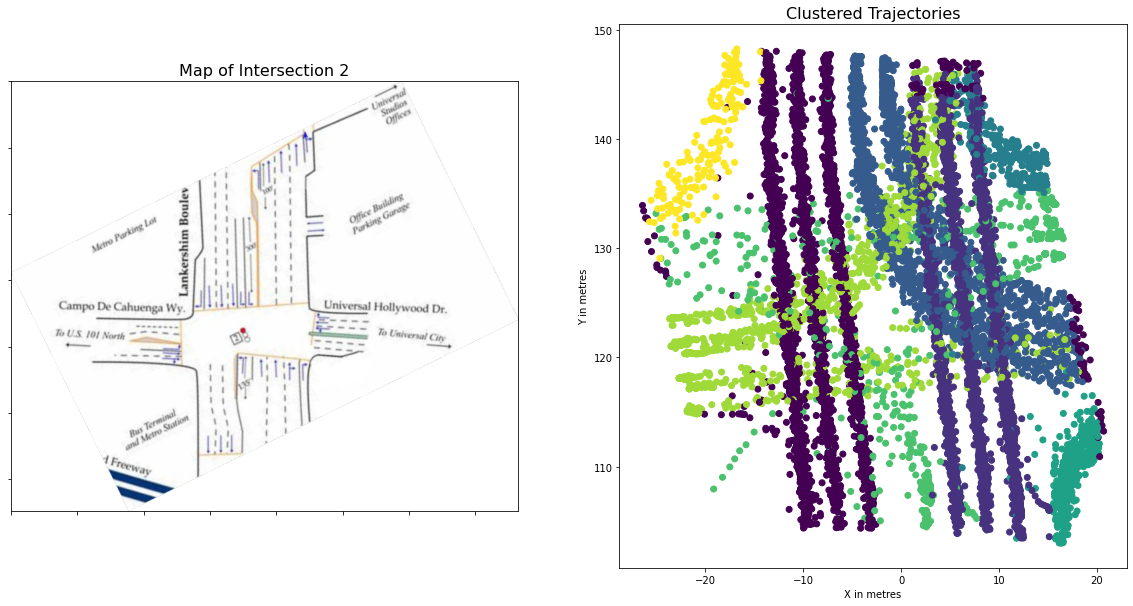

In [5]:
trajectory_data = pd.read_csv("NGSIM__Lankershim_Vehicle_Trajectories.csv")
np.set_printoptions(threshold=np.inf)
#Extract data of vehicles traveled through only the second intersection
trajectory_data_i2 = trajectory_data.loc[trajectory_data['Int_ID'] == 2]

#trajectory_data.
vehicle_id, frame_id,total_frames, global_time, local_X, local_Y = np.array((trajectory_data_i2.Vehicle_ID,
                                                                trajectory_data_i2.Frame_ID,
                                                                trajectory_data_i2.Total_Frames,
                                                                trajectory_data_i2.Global_Time,
                                                                trajectory_data_i2.Local_X,
                                                                trajectory_data_i2.Local_Y))

#Change positions to column vectors and converting ft to metre scale
local_X = local_X.reshape(-1,1)*0.3048
local_Y = local_Y.reshape(-1,1)*0.3048

#get start and end positions of every trajectory considered
vehicle_ids, start_end_pos_indices = get_start_end_positions(vehicle_id)

#Extracting start and end positions of trajectories 
start_pos_X = [local_X[i][0] for i in start_end_pos_indices[:,0]]
start_pos_Y = [local_Y[i][0] for i in start_end_pos_indices[:,0]]

end_pos_X = [local_X[i][0]for i in start_end_pos_indices[:,1]]
end_pos_Y = [local_Y[i][0] for i in start_end_pos_indices[:,1]]


# K-Means clustering algorithm
'''
Note: The Output of K-means clustering is stochastic in nature depending on the
randomly chosen initialization points. Cluster labels, population (to a small 
extent) differs every execution. This only has a negligible impact on the GP 
model training and inference.
'''
k_means_training_data = pd.DataFrame({
    'start_pos_x':start_pos_X,'start_pos_y':start_pos_Y,
    'end_pos_x':end_pos_X,'end_pos_y':end_pos_Y
})

# The number of clusters follows the paper's recommendation
clusters_count = 8
k_means = KMeans(n_clusters=clusters_count)
k_means_model = k_means.fit(k_means_training_data)
trajectory_labels= k_means_model.labels_

position_labels = np.zeros_like(local_X,dtype='int')

for row in range(np.shape(start_end_pos_indices)[0]):
    start_idx = start_end_pos_indices[row][0]
    end_idx   = start_end_pos_indices[row][1]
    position_labels[start_idx:end_idx]=trajectory_labels[row]
  

figure, subplots = plt.subplots(1,2,figsize=(20, 10))
image= mpimg.imread('intersection_2.png')
subplots[0].set_title("Map of Intersection 2",fontsize=16)
subplots[0].set_xticklabels('')
subplots[0].set_yticklabels('')
subplots[0].imshow(image)

subplots[1].set_title("Clustered Trajectories",fontsize=16)
subplots[1].scatter(local_X[::10],local_Y[::10],c=position_labels[::10])
subplots[1].set_xlabel("X in metres")
subplots[1].set_ylabel("Y in metres")


The loaded image ("Map of Intersection 2") was taken from [Lankershim Boulevard Dataset home page](https://www.fhwa.dot.gov/publications/research/operations/07029/index.cfm).

In [6]:
n_devices = torch.cuda.device_count()
print("There is/are {} GPU device/s detected".format(n_devices))
#Setup training data for the GP model
vx = np.zeros_like(local_X)
vy = np.zeros_like(local_Y)

'''
Calculate trajectory derivatives in terms of metres per second from 
metres/0.1 seconds.
'''
for i in range(len(local_X)-1):
    inst_vx = (local_X[i+1]-local_X[i])/0.1
    vx[i] = inst_vx
    inst_vy = (local_Y[i+1]-local_Y[i])/0.1
    vy[i] = inst_vy

#set trajectory derivatives of last positions of vehicles to 0
for indices in start_end_pos_indices[:,1]:
  vx[indices] = 0.0
  vy[indices] = 0.0

gp_training_data = pd.DataFrame({
    'x':local_X.reshape(-1),'y':local_Y.reshape(-1),
    'vx':vx.reshape(-1),'vy':vy.reshape(-1),
    'labels':position_labels.reshape(-1)
})
#dictionary to hold training data split based on their labels
gp_training_data_clustered={}

for cluster in range(clusters_count):
  gp_training_data_clustered[cluster] = gp_training_data.loc[
                                          gp_training_data['labels'] == cluster] 

There is/are 0 GPU device/s detected


In [7]:
#Gaussian Process model definition
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, xy_train, v_train, likelihood):
        super(ExactGPModel, self).__init__(xy_train, v_train, likelihood)
        #Zero mean assumption
        self.mean_module = gpytorch.means.ZeroMean()
        #Squared exponential kernel
        self.covar_module = gpytorch.kernels.ScaleKernel\
                                                  (gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
training = False

if training:
  #Training phase
  epochs = 50
  #indexed by clusters
  train_data_indices = {}

  if torch.cuda.is_available():
    torch.cuda.empty_cache()

  print("Training Starts...\n")
  #Train GP model pairs of every cluster
  for cluster in range(clusters_count):
    print("Cluster = {}\n".format(cluster))
    xy_train = (gp_training_data_clustered[cluster])[['x','y']].to_numpy()

    xy_train = torch.from_numpy(xy_train).float()
    print(f'training_samples = {xy_train.shape[0]}')
    #a pair of models for every cluster
    for velo_comp in ['vx','vy']:
      #v_train denotes the label
      print("Velocity model = {}\n".format(velo_comp))
      v_train = (gp_training_data_clustered[cluster])[[velo_comp]].to_numpy()
      #Explicitly type casted to float to avoid PyTorch error
      v_train = torch.from_numpy(v_train).float()
      #convert v_train to a scalar
      v_train = v_train.reshape(-1)

      #Instantiating the GP model
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      model = ExactGPModel(xy_train,v_train,likelihood)
      if torch.cuda.is_available():
          #Transfer data and model to GPU for training
          xy_train = xy_train.cuda()
          v_train  = v_train.cuda()
          model = model.cuda()
          likelihood = likelihood.cuda()

      #Enable training mode
      model.train()
      likelihood.train()

      # Use the adam optimizer
      #model.parameters() includes GaussianLikelihood parameters
      optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=0.1)

      # "Loss" for GPs - the marginal log likelihood
      mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
      epoch_number=[]
      epoch_loss = []
      for epoch in range(1,epochs+1):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(xy_train)
        # Calc loss and backprop gradients
        loss = -mll(output, v_train)
        loss.backward()
        if epoch%5 == 0:
          model_name = f"./models/cluster_{cluster}/model_{cluster}{velo_comp}{epoch}.pth"
          torch.save(model.state_dict(),model_name)
          print('Epoch %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
              epoch , epochs, loss.item(),
              model.covar_module.base_kernel.lengthscale.item(),
              model.likelihood.noise.item()
          ))
        epoch_number.append(epoch)
        epoch_loss.append(loss.item())
        optimizer.step()


In [9]:
'''check point indices obtained by choosing the best model pairs in for every 
cluster of data'''
chk_point_epoch_vx = [15, 20, 20, 5, 60, 15, 10, 5]
chk_point_epoch_vy = [40, 25, 35, 20, 10, 60, 25, 30]

#Inference
'''
Mechanism to select the best model is required
Cluster Selection Mechanism to be added
'''
'''
chk_point_iter can be replaced by the model with the least loss
'''
matching_cluster = 1

In [10]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()
#disable gradient calculation mode and enable option for faster inference
with torch.no_grad(),gpytorch.settings.fast_pred_var():
  gp_models = {}
  likelihoods = {}

  #future motion predicted for 30 time steps or 3 seconds
  prediction_steps = 10 

  #Test Data
  intersec_to_test = 2

  '''Training data of the chosen cluster has to be given to the model for 
  inference as it acts as the prior for Bayesian Inference'''
  xy_train = (gp_training_data_clustered[matching_cluster])[['x','y']].to_numpy()[0:15000,:]
  xy_train = torch.from_numpy(xy_train).float()

  vx_train = (gp_training_data_clustered[matching_cluster])[['vx']].to_numpy()[0:15000,:]
  vy_train = (gp_training_data_clustered[matching_cluster])[['vy']].to_numpy()[0:15000,:]

  #Explicitly type casted to float to avoid PyTorch error 
  vx_train = torch.from_numpy(vx_train).float()
  vy_train = torch.from_numpy(vy_train).float()
  #convert to a scalar
  vx_train = vx_train.reshape(-1)
  vy_train = vy_train.reshape(-1)

  if torch.cuda.is_available():
  #Transfer data and model to GPU for training
    xy_train = xy_train.cuda()
    vx_train  = vx_train.cuda()
    vy_train = vy_train.cuda()      

  model_file_name = f"./models/cluster{matching_cluster}/model_{matching_cluster}vx{chk_point_epoch_vx[matching_cluster]}.pth"
  state_dict = torch.load(model_file_name)
  #specify the type of likelihood function
  likelihoods['x'] = gpytorch.likelihoods.GaussianLikelihood()
  #training data is required to instantiate ExactGPModel because the model acts as the prior
  gp_models['x'] = ExactGPModel(xy_train, vx_train, likelihoods['x'])  
  gp_models['x'].load_state_dict(state_dict)

  model_file_name = f"./models/cluster{matching_cluster}/model_{matching_cluster}vy{chk_point_epoch_vy[matching_cluster]}.pth"
  state_dict = torch.load(model_file_name)

  likelihoods['y'] = gpytorch.likelihoods.GaussianLikelihood()
  gp_models['y'] = ExactGPModel(xy_train, vy_train, likelihoods['y'])  
  gp_models['y'].load_state_dict(state_dict)

  #enable evaluation mode for the pair of models
  gp_models['x'].eval()
  gp_models['y'].eval()

  likelihoods['x'].eval()
  likelihoods['y'].eval()


  

  #Recommended: Load trajectory information of vehicles from another intersection
  trajectory_data_test = trajectory_data.loc[trajectory_data['Int_ID'] == \
                                             intersec_to_test]
  #trajectory_data.
  vehicle_id, frame_id,total_frames, global_time, local_X, local_Y = np.array((\
                                                trajectory_data_test.Vehicle_ID,
                                                trajectory_data_test.Frame_ID,
                                                trajectory_data_test.Total_Frames,
                                                trajectory_data_test.Global_Time,
                                                trajectory_data_test.Local_X,
                                                trajectory_data_test.Local_Y))


  #Change positions to column vectors and converting ft to metre scale
  local_X = local_X.reshape(-1,1)*0.3048
  local_Y = local_Y.reshape(-1,1)*0.3048

  #get start and end positions of every trajectory considered
  vehicle_ids, start_end_pos_indices = get_start_end_positions(vehicle_id)

  xy_test = np.hstack((local_X,local_Y))

  #first sample to test
  start = start_end_pos_indices[0][0]
  end =  start_end_pos_indices[0][1]

 #Ground truth and the portion of it to be predicted
  xy_test_truth =  xy_test[start:end,:]
  xy_test_sample = xy_test[start:end-prediction_steps,:]

  #inference happens in GPU and therefore data needs to be placed there
  xy_test_sample = torch.from_numpy(xy_test_sample)

  lower_conf_bound = torch.zeros(prediction_steps)
  upper_conf_bound = torch.zeros(prediction_steps)
  xy_test = xy_test_sample.clone()
  xy_test = xy_test.float()

  #transfer all data to the GPU for inference

  if torch.cuda.is_available():
    xy_test = xy_test.cuda()
    gp_models['x'] = gp_models['x'].cuda() 
    gp_models['y'] = gp_models['y'].cuda()
  
    likelihoods['x'] = likelihoods['x'].cuda()
    likelihoods['y'] = likelihoods['y'].cuda()

  for time_step in range(prediction_steps):
    posterior_dist_vx = likelihoods['x'](gp_models['x'](xy_test))
    mean_vx = posterior_dist_vx.mean
    posterior_dist_vy = likelihoods['y'](gp_models['y'](xy_test))
    mean_vy = posterior_dist_vy.mean
    #Add derivatives to the last known position to get the new position
    next_position = xy_test[-1] +\
                                  torch.stack((mean_vx[-1]*0.1,mean_vy[-1]*0.1))
    #transform the position to a row vector
    next_position = torch.transpose(next_position.unsqueeze(-1),0,1)
    ''' 
    Update the prior knowledge (set of known positions). The newly estimated
    position's derivatives would be inferred from the GP model.
    '''
    xy_test = torch.cat((xy_test,next_position),dim=0)
    #if(time_step == prediction_steps-1):
    lower_conf_bound_vx, upper_conf_bound_vx = posterior_dist_vx.\
                                                        confidence_region()
    lower_conf_bound_vy, upper_conf_bound_vy = posterior_dist_vy.\
                                                        confidence_region()  

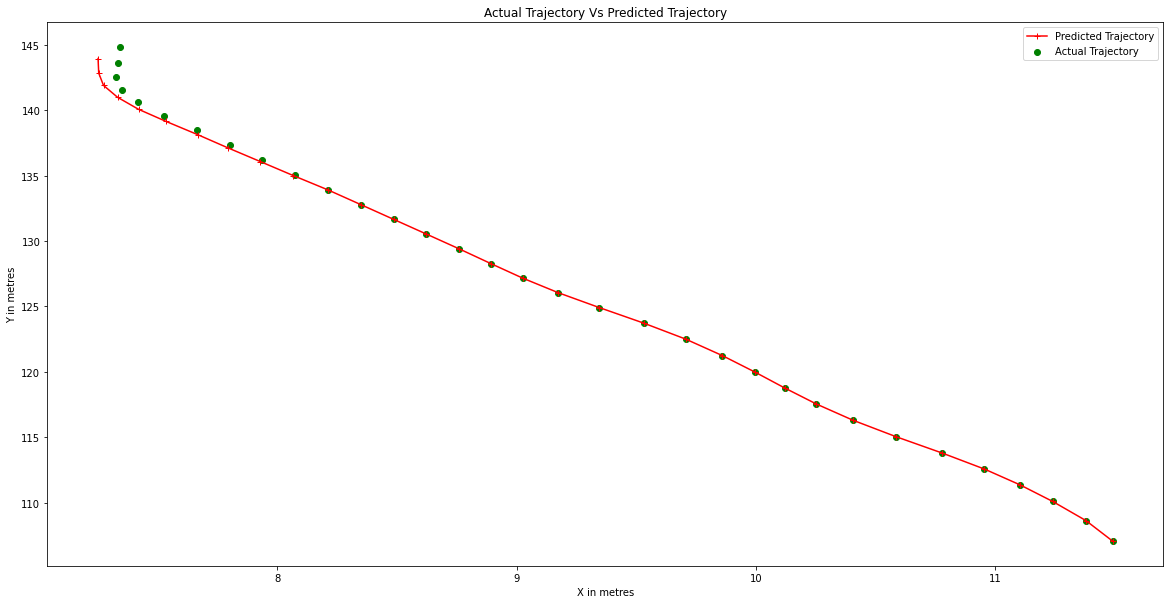

In [11]:
  if torch.cuda.is_available(): 
    #Place variables on CPU for plotting
    xy_test = xy_test.cpu().numpy()
    lower_conf_bound_vx = lower_conf_bound_vx.cpu().numpy() 
    upper_conf_bound_vx = upper_conf_bound_vx.cpu().numpy()
  
  #plot outputs
  figure, subplots = plt.subplots(1,1,figsize=(20,10))
  subplots.scatter(xy_test_truth[:,0],xy_test_truth[:,1],color='green',\
                   label='Actual Trajectory')
  subplots.plot(xy_test[:,0],xy_test[:,1],color='red',marker='+',\
                label='Predicted Trajectory')
  subplots.set_xlabel('X in metres')
  subplots.set_ylabel('Y in metres')
  subplots.set_title("Actual Trajectory Vs Predicted Trajectory")
  subplots.legend()